# Analysis of US Past, Present, and Future Riskless rates as represented by Fed Funds Rates and 10-Year Treasury Yields
The Federal Funds Rate and 10-year Treasury Securities yield are used as short-term and long-term riskfree rates respectively. The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to other banks in need of larger balances.10-Year Treasury Yield indicates the rate at which U.S. Department of the Treasury can presently borrow from the public. 

There's a relationship between riskfree rates (e.g. 10-year Treasury rates) and CPI + real GDP growth rates. CPI + GDP growth rates is known as _the intrinsic riskfree rate_. In theory the 10-year Treasury rate should be similar to the intrinsic riskfree rate. 

Unlike the [US CPI, Fed Funds Effective Rate, Market Yield on US Treasury Securities at 10-Year... notebook](https://github.com/ilchen/US_Economic_Data_Analysis/blob/main/CPI_and_Fed_Funds_Rates.ipynb) where I look at monthly changes in riskfree rates, expected inflation, and riskless curves, in this notebook I concentrate on inferring future Fed Funds rates and 10-year Treasury Yields from the futures contracts traded on CME and depict the past, present, and future riskfree rates in one graph.

I then go on to construct the current riskfree curve (based on the most recent US Treasury Yields of different maturities) as well as current real rates curve based on the most recent Treasury inflation protected security (TIPS) yields of different maturities.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay, MonthBegin, MonthEnd
from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves, futures_rates

## Past, Present, and Future: Fed Funds Rates and 10-year Treasury Yields

In [3]:
report_end = date.today()
report_start = report_end - relativedelta(months=+28)

In [4]:
dff_tr10 = web.get_data_fred(['DFF', 'DGS10'], start=report_start, end=report_end) / 100.

In [5]:
# Resampling to monthly frequencies by taking the average for each month,
# but using the last price for the current month
ff_tr10 = pd.concat([dff_tr10.loc[:report_end - MonthEnd()].resample('MS').mean(),
                     dff_tr10.loc[report_end - MonthEnd() + BDay():].resample('MS').last()])

In [6]:
# Inferring future Fed Funds and 10 Year Treasury Note yields for the futures contracts traded on CME
inverrer_ff_rates = futures_rates.CMEFedFundsFuturesRates(report_end)
inverrer_tnote_yields = futures_rates.CME10YearTNoteFuturesYields(report_end)
ff_rates = inverrer_ff_rates.get_rates_for_next_n_months(18)
tr10_yields = inverrer_tnote_yields.get_yields_for_next_n_quarters(2)

Objective function: -0.00031 after 17 iterations
Objective function: -0.00136 after 18 iterations


In [7]:
# Renaming the future Fed Funds and T-Note series to have the same name as those retrieved earlier
ff_rates.rename(ff_tr10.columns[0], inplace=True)
tr10_yields.rename(ff_tr10.columns[1], inplace=True)

# Concatenating future rates and yields into a DataFrame
future_rates = pd.concat([ff_rates, tr10_yields], axis=1)

In [8]:
# And now merging the past, current, and future rates/yields 
ext_ff_tr10 = pd.concat([ff_tr10, future_rates])
ext_ff_tr10.rename(
    columns={'DFF': 'Federal Funds Effective Rate',
             'DGS10': '10y Treasury Yield'},
    inplace=True)

### Note on 10-year T-None Futures contracts
Unfortunately only the contracts for the next two quarters are actively traded for [this instrument](https://www.cmegroup.com/markets/interest-rates/us-treasury/10-year-us-treasury-note.quotes.html) on CME. I interpolate for the missing months.

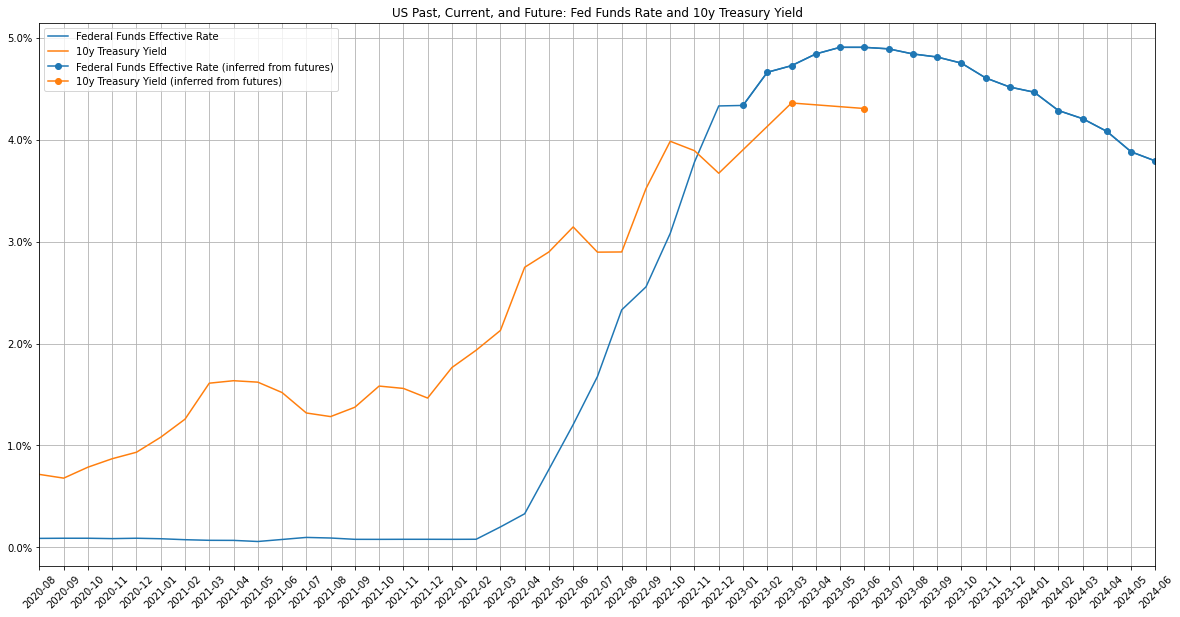

In [9]:
FROM_FUTURES = ' (inferred from futures)'
from_idx = ext_ff_tr10.iloc[:, 1].isna().idxmax()
interp = ext_ff_tr10.interpolate()
interp.loc[tr10_yields.index[-1]+MonthBegin():, ext_ff_tr10.columns[1]] = np.nan
ax = interp.plot(figsize=(20,10), grid=True, title='US Past, Current, and Future: Fed Funds Rate and 10y Treasury Yield',
                 xticks=ext_ff_tr10.index, xlabel='', rot=45)
ext_ff_tr10.loc[from_idx:].rename(
    columns={ext_ff_tr10.columns[0]: ext_ff_tr10.columns[0] + FROM_FUTURES,
             ext_ff_tr10.columns[1]: ext_ff_tr10.columns[1] + FROM_FUTURES})\
        .plot(ax=ax, grid=True, marker='o', xticks=ext_ff_tr10.index, xlabel='',
              rot=45, yticks=np.arange(0, .06, 0.01), color=['#1f77b4','#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ext_ff_tr10.index)))

## Current US Treasury and US Real Rates Curves
Real rates are yields on Treasury inflation protected security (TIPS). The reason they are called _real_ is because an investor into a TIPS security is automatically compensated for CPI inflation. That the current yield on a TIPS security is the rate of return an investor gets when inflation is accounted for.

Unfortunately the Fed only publishes TIPS yields for a limited set of constant maturities: 5 years, 7 years, 10 years, 20 years, and 30 years. In the following part of the notebook I constract the missing maturities for 1 and 2 years by subtracting the most recent expected inflation for 1 and 2 years from treasury yields of the same maturities. For the instant real rate I subtract the most recent CPI from the most recent Fed Funds rate.

In [10]:
today = date.today()

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - BDay(2), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion to APY: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=2)

In [11]:
real_rates = web.get_data_fred(['DFII5', 'DFII7', 'DFII10', 'DFII20', 'DFII30'], today - BDay(2), today) / 100.
real_rates.dropna(inplace=True)

# Infer real rates from the most recent expected inflation and current treasury yields
expected_infl = web.get_data_fred(['EXPINF1YR', 'EXPINF2YR'], today - MonthBegin(2), today) / 100.
real_rates_1y_2y = data.iloc[-1,[4,5]].set_axis(expected_infl.iloc[-1,:].index) - expected_infl.iloc[-1,:]
real_rates.insert(0, 'DFII2', real_rates_1y_2y[1])
real_rates.insert(0, 'DFII1', real_rates_1y_2y[0])

# Infer the current real rate from the difference between most recent Fed Funds Rate and CPI
cpi = web.get_data_fred('CPIAUCSL', today - MonthBegin(14), today).pct_change(12)
real_rates.insert(0, 'INST', dff_tr10.iloc[-1,0]-cpi.iloc[-1,0])

# Unfortunately fewer curve points for TIPS
offsets_tips = [relativedelta(), relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+5),
                relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]
curve_real_rates = curves.YieldCurve(today, offsets_tips, real_rates[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                                     compounding_freq=2)

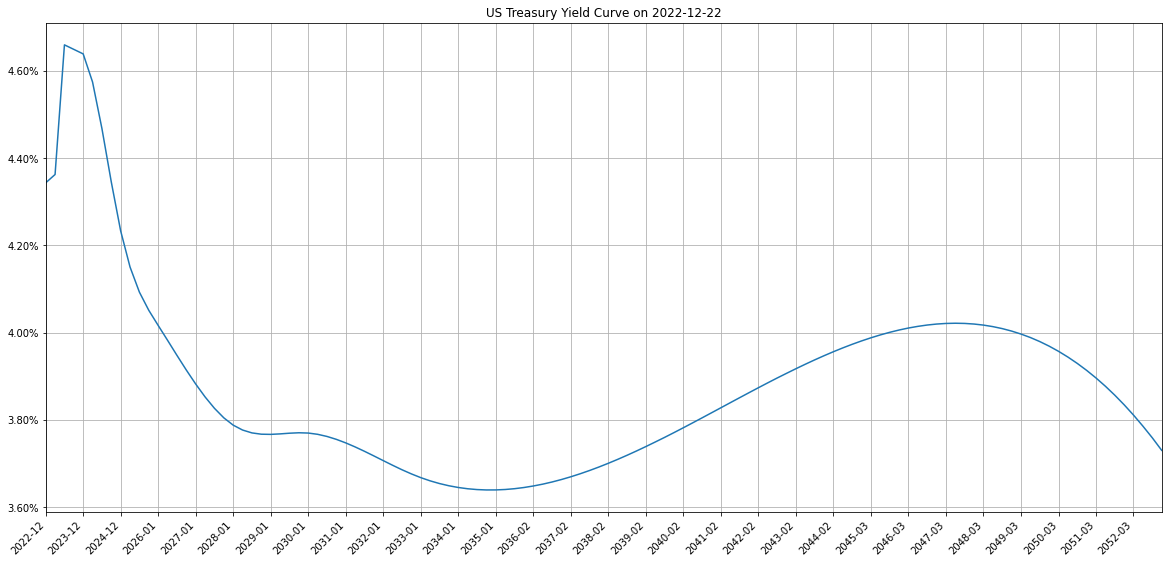

In [12]:
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, curve_points.index[::4])))

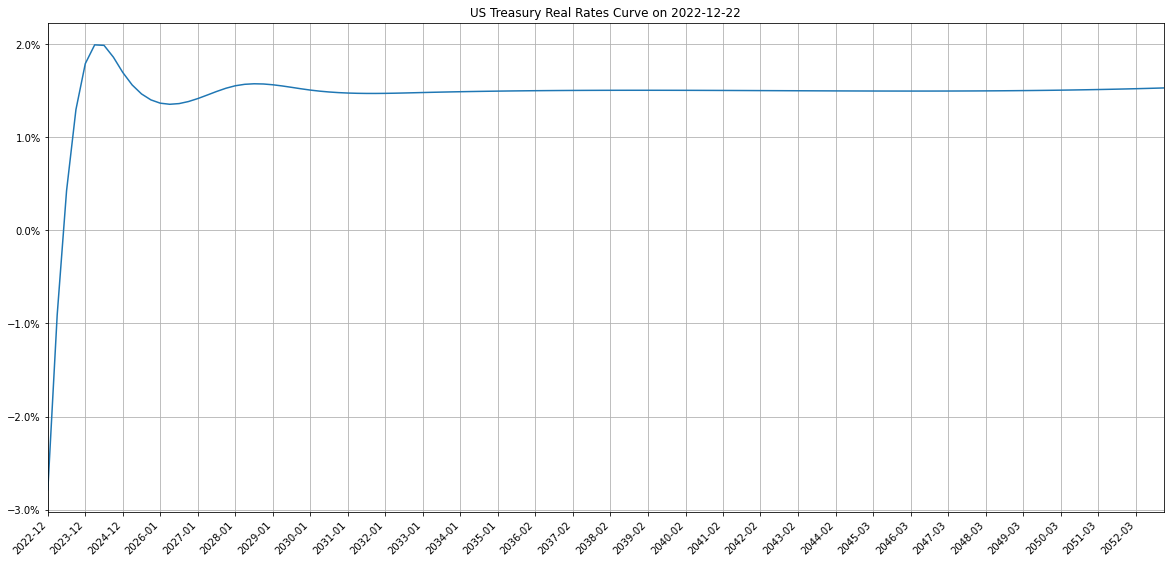

In [13]:
curve_points = curve_real_rates.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Real Rates Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, curve_points.index[::4])))